In [3]:
# Standard libraries
import os
import math
import time

# Data manipulation and analysis
import numpy as np
import pandas as pd

#Data Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

# datetime index
from datetime import datetime,date,timedelta

# Machine Learning - Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, ParameterGrid, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  MinMaxScaler, StandardScaler

# Satistical analysis- SARIMAX (statsmodels)
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product 

import warnings
warnings.filterwarnings('ignore')


In [4]:
# Readin the data set kepping date as index
df=pd.read_csv('weighted_sum.csv')

# Make the 'date' column as index of the DataFrame
df.index = df["date"].values

df.index = pd.to_datetime(df.index)

df.drop(columns='date', inplace=True)

# Reindexing DataFrame with pd.date_range, ensure df spans a specified period, filling in any gaps with NaN values.
idx = pd.date_range('2019-10-24', '2023-12-06')

df = df.reindex(idx)

# filter out the specified data range contaning zero
df=df.drop(df.loc['2023-05-12':'2023-07-27'].index)

# Filter out the initial date range considering machine unstability
df=df.drop(df.loc['2019-10-24':'2020-01-31'].index)


rows_to_fill = np.where(df["weighted_sum"].isna())

for row in rows_to_fill:

    df.iloc[row] = df.iloc[row + 7]

# Replace negative values with zero in 'weighted_sum'
df['weighted_sum'] = df['weighted_sum'].clip(lower=0)

# replace 7 irregular data points with 8th highest value.
df[df['weighted_sum']>570]=570

print(df)

            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
...                  ...
2023-12-02    114.049422
2023-12-03      0.000000
2023-12-04    226.893157
2023-12-05    390.659238
2023-12-06    425.322937

[1328 rows x 1 columns]


### SARIMA model fit using SARIMAX function with selected parameter from grid search

In [7]:

# Define the train-test split parameters
initial_train_size = int(0.7 * len(df))  # Start with 70% training data
n_splits = len(df) - initial_train_size  # Remaining data for testing
test_size = 1 # Fixed test set size for each fold

n_folds = n_splits // test_size
print(f'\nNumber of folds: {n_folds}')
print(f"\nInitial train size: {initial_train_size}, Number of splits: {n_splits}")


# Initialize list to store RMSE values for each fold
mse_test_values = []
mse_train_values = []

# Store predictions to compare later
predictions_test_all = []
predictions_train_all = []

# Iterate through the rolling cross-validation process
for i in range(0, n_splits, test_size):
    
    # Define the end points for the current fold
    train_end = initial_train_size + i
    test_end = min(train_end + test_size, len(df))  # Ensure not to exceed data length

    # Define the current training and test data for this split
    train_data = df.iloc[:train_end]
    test_data = df.iloc[train_end:test_end]

    # Fit the SARIMAX model
    model = SARIMAX(train_data, 
                    order=(0, 0, 0), 
                    seasonal_order=(3, 1, 1, 7), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False) 

    model_fit = model.fit(disp=False)

    # Make predictions on the test data
    predictions_test = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    predictions_train = model_fit.predict(start=0, end=len(train_data) - 1)
    
    predictions_test_all.append(predictions_test)
    predictions_train_all.append(predictions_train)

    # Calculate RMSE on the test data
    mse_test = mean_squared_error(test_data, predictions_test)
    mse_train = mean_squared_error(train_data, predictions_train)

    mse_test_values.append(mse_test)
    mse_train_values.append(mse_train)
       
    print(f'\nFold {i // test_size + 1} Test MSE: {mse_test:.4f}')
    print(f'\nFold {i // test_size + 1} Train MSE: {mse_train:.4f}')

# After all folds, calculate the average MSE for both train and test
average_mse_test_all = np.mean(mse_test_values)
average_mse_train_all = np.mean(mse_train_values)

# Calculate RMSE from the average MSE
rmse_test = np.sqrt(average_mse_test_all)
rmse_train = np.sqrt(average_mse_train_all)

print(f"Average Test RMSE across all folds: {rmse_test:.4f}")
print(f"Average Train RMSE across all folds: {rmse_train:.4f}")


Number of folds: 399

Initial train size: 929, Number of splits: 399

Fold 1 Test MSE: 43959.1816

Fold 1 Train MSE: 7773.3345

Fold 2 Test MSE: 2596.1633

Fold 2 Train MSE: 7811.6066

Fold 3 Test MSE: 1166.2346

Fold 3 Train MSE: 7805.7713

Fold 4 Test MSE: 90.0626

Fold 4 Train MSE: 7798.7021

Fold 5 Test MSE: 14.7283

Fold 5 Train MSE: 7790.4484

Fold 6 Test MSE: 5342.3017

Fold 6 Train MSE: 7782.1357

Fold 7 Test MSE: 637.2444

Fold 7 Train MSE: 7779.3487

Fold 8 Test MSE: 4019.1224

Fold 8 Train MSE: 7771.6503

Fold 9 Test MSE: 1140.9875

Fold 9 Train MSE: 7767.6896

Fold 10 Test MSE: 2893.8279

Fold 10 Train MSE: 7760.3975

Fold 11 Test MSE: 87.0562

Fold 11 Train MSE: 7755.5086

Fold 12 Test MSE: 9687.0702

Fold 12 Train MSE: 7747.3575

Fold 13 Test MSE: 69.0188

Fold 13 Train MSE: 7749.0950

Fold 14 Test MSE: 682.7713

Fold 14 Train MSE: 7740.9375

Fold 15 Test MSE: 1545.3666

Fold 15 Train MSE: 7733.2945

Fold 16 Test MSE: 1871.5947

Fold 16 Train MSE: 7727.0908

Fold 17 Test

[SARIMA[(0, 0, 0)x(0, 1, 0, 7)]] Average Test RMSE across all folds: 126.7711, Average Train RMSE across all folds: 114.6185  

[SARIMA[(1, 1, 1)x(1, 0, 1, 7)]] Average Test RMSE across all folds: 93.7203, Average Train RMSE across all folds: 83.3736

[SARIMA[(2, 1, 1)x(1, 0, 2, 7)]] Average Test RMSE across all folds: 97.5257, Average Train RMSE across all folds: 89.0638

[SARIMA[(0, 0, 0)x(3, 1, 1, 7)]] Average Test RMSE across all folds: 89.4864, Average Train RMSE across all folds: 88.3900

#### Model Diagnostic check for SARIMA[(1, 1, 1)x(1, 0, 1, 7)]

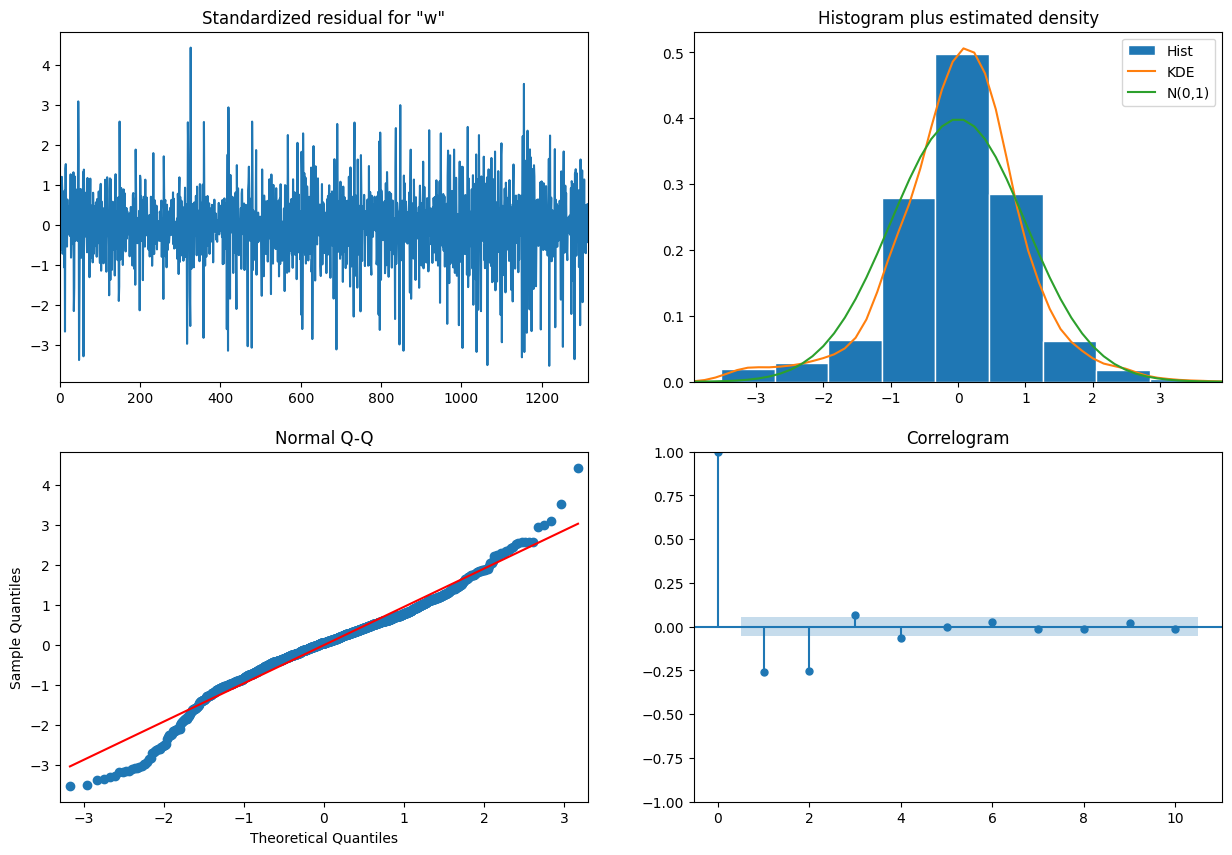

In [122]:
import statsmodels.api as sm
model_fit.plot_diagnostics(figsize=(15, 10))
plt.savefig('model diagonostic')

In [11]:
# Now, split the initial training data into 70% training and 30% validation
train_size = int(0.7 * len(df))
train_data = df.iloc[:train_size]  # Use iloc to slice without losing the index
test_data = df.iloc[train_size:]    # Use iloc to slice without losing the index

# Print the shapes and check the indices
print(train_data.shape, test_data.shape)

# Display the train and test data with the original date index
print(train_data.head())
print(test_data.head())

(929, 1) (399, 1)
            weighted_sum
2020-02-01    239.210369
2020-02-02     28.280318
2020-02-03    199.366981
2020-02-04    423.067131
2020-02-05    409.692107
            weighted_sum
2022-08-18    193.901423
2022-08-19    432.053452
2022-08-20    134.239967
2022-08-21      0.000000
2022-08-22    293.099946


#### Convert predictions_all (which is a list of arrays) into a flat array

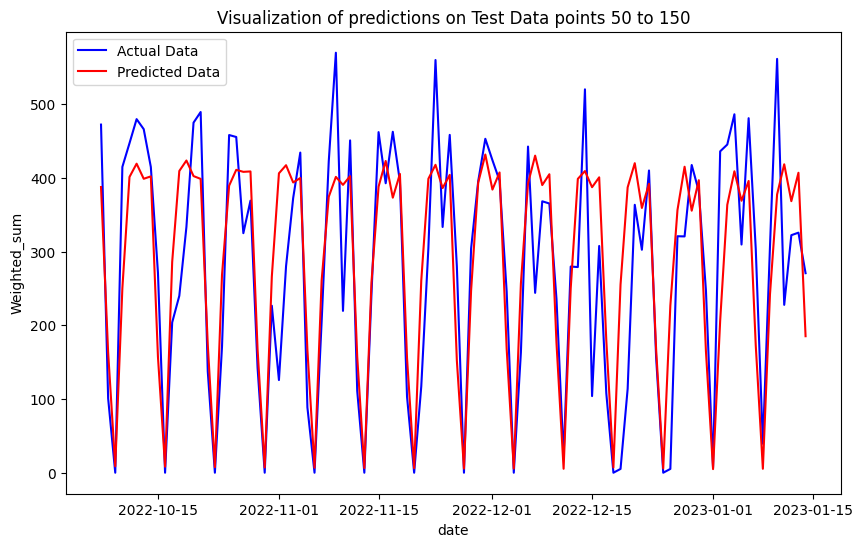

In [14]:
# Convert predictions_all (which is a list of arrays) into a flat array
predictions_test_flat = np.concatenate(predictions_test_all)
predictions_test_flat= predictions_test_flat.clip(min=0)

# Convert the index of test_data to DatetimeIndex
test_data.index = pd.to_datetime(test_data.index)
# Plot the actual values and the predictions
plt.figure(figsize=(10,6))

# Use the date index from the test data for the x-axis
plt.plot(test_data.index[50:150], test_data[50:150], label='Actual Data', color='blue')

# Plot the predictions aligned with the same date indices as test_data
plt.plot(test_data.index[50:150], predictions_test_flat[50:150], label='Predicted Data', color='red')

# Add title and labels
plt.title('Visualization of predictions on Test Data points 50 to 150')
plt.xlabel('date')
plt.ylabel('Weighted_sum')

# Add legend
plt.legend()

plt.savefig('prediction_test')
# Show the plot
plt.show()

#### Prediction of SARIMA[(1, 1, 1)x(1, 0, 1, 7)]] on test data

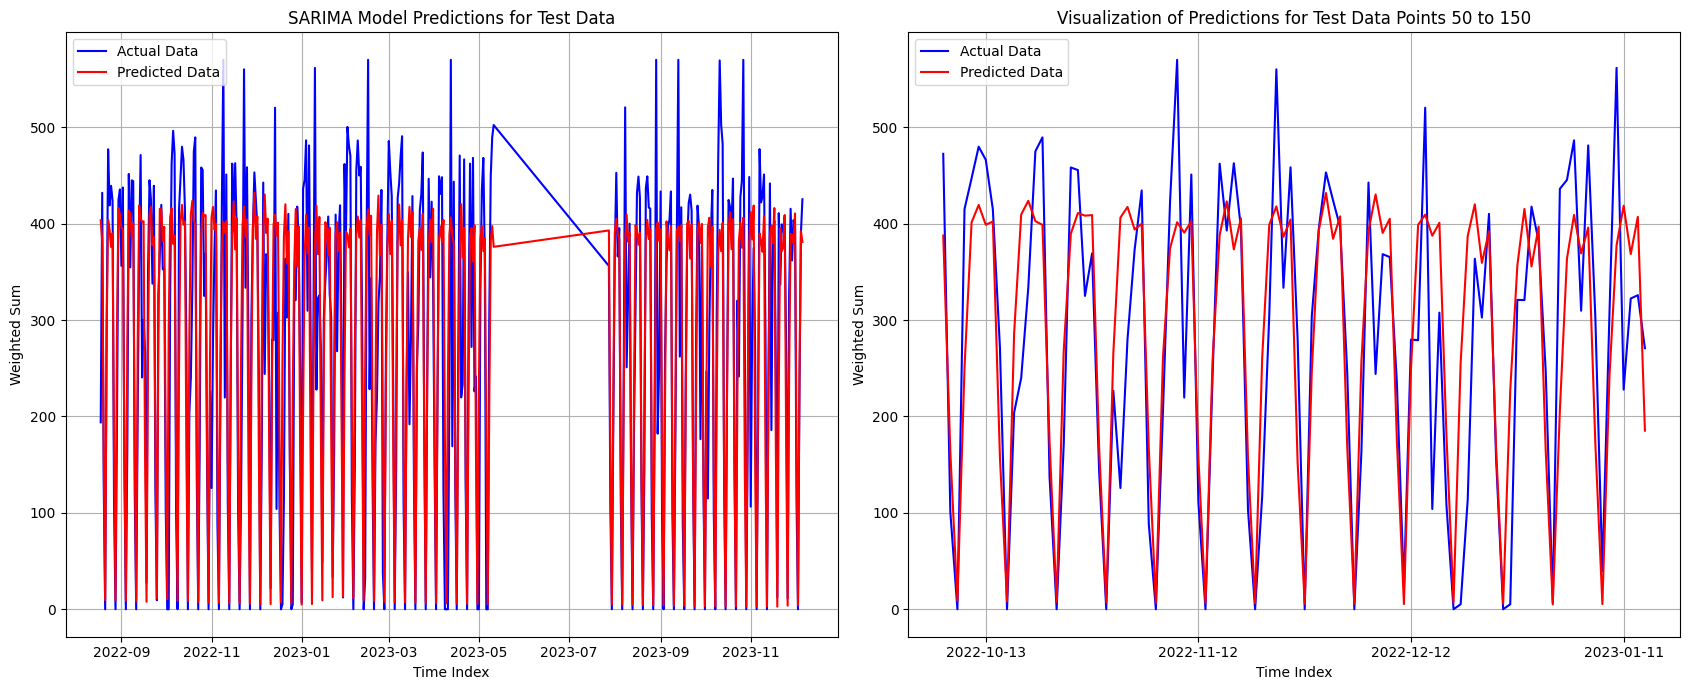

In [17]:

# Convert the index of test_data to DatetimeIndex
test_data.index = pd.to_datetime(test_data.index)

# Create a figure with specific size
fig = plt.figure(figsize=(17, 7))

# Create a gridspec layout: 1 row, 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])  # Adjust the width ratios as needed

# Plot LSTM Model Predictions for test data
ax1 = fig.add_subplot(gs[0])
ax1.plot(test_data.index, test_data, label='Actual Data', color='blue')
ax1.plot(test_data.index, predictions_test_flat, label='Predicted Data', color='red')
ax1.legend()
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Weighted Sum')
ax1.set_title('SARIMA Model Predictions for Test Data')
ax1.grid(True)  # Adding grid lines

# Plot LSTM Model Predictions for train data
ax2 = fig.add_subplot(gs[1])
ax2.plot(test_data.index[50:150], test_data.values[50:150], label='Actual Data', color='blue')
ax2.plot(test_data.index[50:150], predictions_test_flat[50:150], label='Predicted Data', color='red')
ax2.legend()
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Weighted Sum')
ax2.set_title('Visualization of Predictions for Test Data Points 50 to 150')

# Set x-axis ticks to every 7 days
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax2.grid(True)  # Adding grid lines

# Improve the layout
plt.tight_layout()

# Save the figure as a single image
plt.savefig('SARIMA_test_Predictions.png')

# Display the plots
plt.show()


#### Prediction of SARIMA[(1, 1, 1)x(1, 0, 1, 7)]]  on train data

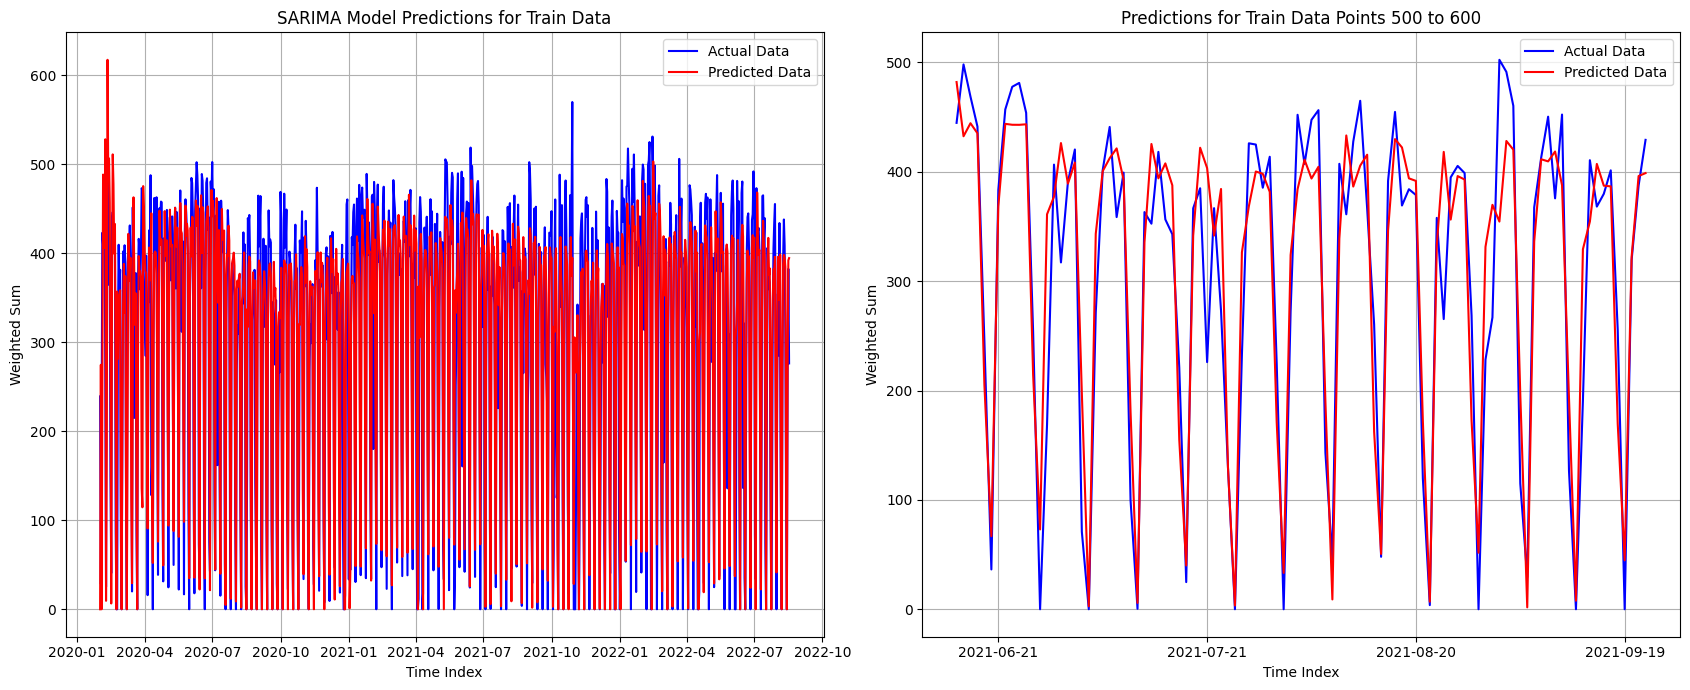

In [130]:

predictions_train_flat = np.concatenate(predictions_train_all)
predictions_train_flat= predictions_train_flat.clip(min=0)

# Convert the index of test_data to DatetimeIndex
train_data.index = pd.to_datetime(train_data.index)

# Create a figure with specific size
fig = plt.figure(figsize=(17, 7))

# Create a gridspec layout: 1 row, 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])  # Adjust the width ratios as needed

# Plot LSTM Model Predictions for test data
ax1 = fig.add_subplot(gs[0])
ax1.plot(train_data.index, train_data, label='Actual Data', color='blue')
ax1.plot(train_data.index, predictions_train_flat[0:929], label='Predicted Data', color='red')
ax1.legend()
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Weighted Sum')
ax1.set_title('SARIMA Model Predictions for Train Data')
ax1.grid(True)  # Adding grid lines

# Plot LSTM Model Predictions for train data
ax2 = fig.add_subplot(gs[1])
ax2.plot(train_data.index[500:600], train_data.values[500:600], label='Actual Data', color='blue')
ax2.plot(train_data.index[500:600], predictions_train_flat[500:600], label='Predicted Data', color='red')
ax2.legend()
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Weighted Sum')
ax2.set_title('Predictions for Train Data Points 500 to 600')

# Set x-axis ticks to every 7 days
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=30))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax2.grid(True)  # Adding grid lines

# Improve the layout
plt.tight_layout()

# Save the figure as a single image
plt.savefig('SARIMA_train_Predictions.png')

# Display the plots
plt.show()
